# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in one forms
. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import os

In [2]:
# loading previous cleaned dataset
import sqlite3
con = sqlite3.connect("final.sqlite")

In [3]:
data = pd.read_sql_query("select * from Reviews", con)

In [4]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [5]:
final = data
# Sort data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")
final['Score'] = (final.Score.str.match('positive')).astype(int)
final.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [6]:
df = pd.DataFrame({"text" : final.CleanedText[0:50000].values,"score":final.Score[0:50000].values})
df.head()

,text,score
0,witti littl book make son laugh loud recit car...,1
1,rememb see show air televis year ago child sis...,1
2,beetlejuic well written movi everyth excel act...,1
3,twist rumplestiskin captur film star michael k...,1
4,beetlejuic excel funni movi keaton hilari wack...,1


In [13]:
df.to_pickle("file_name.pkl")

In [16]:
df2 = pd.read_pickle("./file_name.pkl")
df2.score.head()

0    1
1    1
2    1
3    1
4    1
Name: score, dtype: int64

,text,score
0,describ sweet crunchi phillo dough pastri love...,1
1,saint lucian baron hot sauc serv island saint ...,1
2,far favorit snack food also happen one lundber...,1
3,use air pop popcorn replac microwav popcorn fi...,1
4,best rum cake return bahama brought sever diff...,1


In [15]:
#initialing the table
from prettytable import PrettyTable
tableData = PrettyTable()
tableData.field_names = ["Vectorizer", "Model", "alpha", "AUC"]
print(tableData)

+------------+-------+-------+-----+
| Vectorizer | Model | alpha | AUC |
+------------+-------+-------+-----+
+------------+-------+-------+-----+


In [7]:
# 60% of data as Train
X_tr = final.CleanedText[0:60000]
y_tr = final.Score[0:60000]

# % 20 percent of data as CV
X_cv = final.CleanedText[60000:80000]
y_cv = final.Score[60000:80000]

# 20% of dataas test
X_test = final.CleanedText[80000:100000]
y_test = final.Score[80000:100000]

print("train data shape ",X_tr.shape," ",y_tr.shape )
print("Cv data shape ",X_cv.shape," ",y_cv.shape )
print("test data shape ",X_test.shape," ",y_test.shape )

train data shape  (60000,)   (60000,)
Cv data shape  (20000,)   (20000,)
test data shape  (20000,)   (20000,)


In [8]:
#to standarize the data with zero mean and one variance
scale = StandardScaler(with_mean = False)

# [4] Featurization

## [4.1] BAG OF WORDS

In [9]:
# since my ram is only 4gb so i am performing Bag Of Words operation on 100k data only
#BOW
count_vect = CountVectorizer(max_features=5000, min_df=10) #in scikit-learn
bowTrain = count_vect.fit_transform(X_tr.values)
print("the type of count vectorizer ",type(bowTrain))
print("the shape of out text BOW vectorizer ",bowTrain.get_shape())
print("the number of unique words ", bowTrain.get_shape()[1])

bowTrain = scale.fit_transform(bowTrain)

bowCv = count_vect.transform(X_cv.values)
print("the type of count vectorizer ",type(bowCv))

bowCv = scale.fit_transform(bowCv)


bowTest = count_vect.transform(X_test.values)
print("the type of count vectorizer ",type(bowTest))
bowTest = scale.fit_transform(bowTest)


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 5000)
the number of unique words  5000


/home/raviranjan0631/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/raviranjan0631/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


/home/raviranjan0631/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/raviranjan0631/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


/home/raviranjan0631/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/raviranjan0631/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## [4.3] TF-IDF

In [10]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=5000,min_df = 10)
tfTrain = tf_idf_vect.fit_transform(X_tr.values)
print("the type of count vectorizer ",type(tfTrain))
print("the shape of out text tfidf vectorizer ",tfTrain.get_shape())

tfTrain = scale.fit_transform(tfTrain)


tfCv = tf_idf_vect.transform(X_cv.values)
print("the type of count vectorizer ",type(tfCv))
print("the shape of out text tfidf vectorizer ",tfCv.get_shape())

tfCv = scale.fit_transform(tfCv)



tfTest = tf_idf_vect.transform(X_test.values)
print("the type of count vectorizer ",type(tfTest))
print("the shape of out text tfidf vectorizer ",tfTest.get_shape())

tfTest = scale.fit_transform(tfTest)



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (60000, 5000)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (20000, 5000)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (20000, 5000)


## [4.4] Word2Vec

In [11]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
#word2vec
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent = []
for sent in X_tr.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [13]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 


In [14]:
w2v = w2v_model[w2v_model.wv.vocab]

In [15]:
w2v.shape

(9957, 50)

In [16]:
w2v_model.wv.most_similar('similar')

[('typic', 0.7028923630714417),
 ('compar', 0.6715496182441711),
 ('lighter', 0.6174361109733582),
 ('unlik', 0.6078922748565674),
 ('familiar', 0.6026565432548523),
 ('comparison', 0.5975757241249084),
 ('normal', 0.5880773067474365),
 ('generic', 0.5757439136505127),
 ('lack', 0.557818591594696),
 ('decent', 0.5577421188354492)]

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [17]:
# average Word2Vec on train data
train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    train.append(sent_vec)
print(len(train))
print(len(train[0]))
# To replace nan with 0 and inf with large finite number

train = np.nan_to_num(train)
avgTrain = train

60000
50


In [18]:
avgTrain = scale.fit_transform(avgTrain)


In [19]:
# average Word2Vec on cross validate data
list_of_sent_cv = []
for sent in X_cv.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_cv.append(filtered_sentence)
    
# average Word2Vec on train data
cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    cv.append(sent_vec)
print(len(cv))
print(len(cv[0]))
# To replace nan with 0 and inf with large finite number

cv = np.nan_to_num(cv)
avgCv = cv

20000
50


In [20]:
avgCv = scale.fit_transform(avgCv)


In [21]:
# average Word2Vec on test data
list_of_sent_test = []
for sent in X_test.values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
    
# average Word2Vec on train data
test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    test.append(sent_vec)
print(len(test))
print(len(test[0]))
# To replace nan with 0 and inf with large finite number

test = np.nan_to_num(test)
avgTest = test

20000
50


In [22]:
avgTest = scale.fit_transform(avgTest)


#### [4.4.1.2] TFIDF weighted W2v

In [23]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    train1.append(sent_vec)
    row += 1
    
train1 = np.nan_to_num(train1)
len(train1)
tfAvgTrain = train1
print(tfAvgTrain.shape)

(60000, 50)


In [24]:
tfAvgTrain = scale.fit_transform(tfAvgTrain)


In [25]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    test1.append(sent_vec)
    row += 1
    
test1 = np.nan_to_num(test1)
len(test1)
tfAvgTest = test1

In [26]:
tfAvgTest = scale.fit_transform(tfAvgTest)


In [27]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for train review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    cv1.append(sent_vec)
    row += 1
    
cv1 = np.nan_to_num(cv1)    
len(cv1)
tfAvgCv = cv1

In [28]:
tfAvgCv = scale.fit_transform(tfAvgCv)


In [29]:
#initialing the table
from prettytable import PrettyTable
tableData = PrettyTable()
tableData.field_names = ["Vectorizer", "penalty", "lambda", "AUC"]
print(tableData)

+------------+---------+--------+-----+
| Vectorizer | penalty | lambda | AUC |
+------------+---------+--------+-----+
+------------+---------+--------+-----+


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [30]:
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
lambdaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [31]:
for lam in lambdaValues:
    lr = LogisticRegression(penalty = 'l1', C = lam)
    lr.fit(bowTrain, y_tr)
    predTrain = lr.predict_proba(bowTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = lr.predict_proba(bowCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(lam, " lambda iteration done")

0.0001  lambda iteration done
0.001  lambda iteration done
0.01  lambda iteration done
0.1  lambda iteration done
1  lambda iteration done
10  lambda iteration done
100  lambda iteration done
1000  lambda iteration done
10000  lambda iteration done


In [35]:
print(aucCv)
# print(aucTrain)


[0.5, 0.8394142646463362, 0.9265521991942236, 0.9063353559749966, 0.8797607552027422, 0.8717225835390949, 0.8672301101545419, 0.8636599590024081, 0.861011285059003]


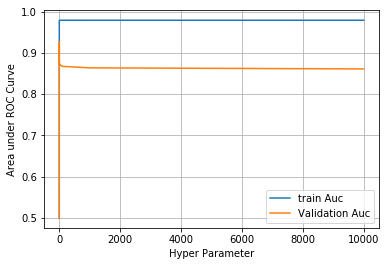

In [34]:
plt.plot(lambdaValues,aucTrain, label='train Auc')
plt.plot(lambdaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


## Observation 
for c = 0.01 we get maximum AUC for CV dataset

In [37]:
lrBow = LogisticRegression(penalty = 'l1', C = 0.01)
# train model knn with respect to ooptimalK
lrBow.fit(bowTrain, y_tr)

predTrain = lrBow.predict_proba(bowTrain)
predTest = lrBow.predict_proba(bowTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
aucTrain = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, predTest[:,1])
aucTest = metrics.auc(fpr2, tpr2)
    
print(aucTest)
y_pred = lrBow.predict(bowTest)

0.9283537214602635


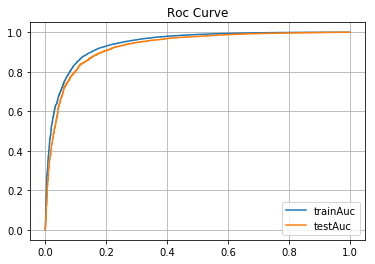

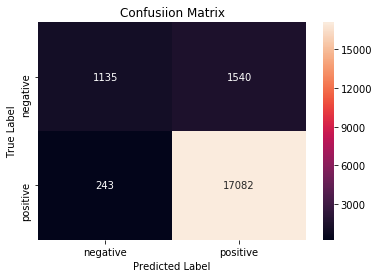

In [39]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [40]:
print(aucTest)

0.9283537214602635


In [41]:
tableData.add_row(['BOW', "l1", 0.01, aucTest])


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [43]:
# Please write all the code with proper documentation
weights = lrBow.coef_
weights.shape

(1, 5000)

In [44]:
count = 0
for i in range(5000):
    if weights[0][i] < 0.0001:
        count += 1
count

4499

#### Observation
so out of 5000 weights, 4499 weights get zero due to use of l1 regularizer

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [45]:
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
lambdaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [46]:
# Please write all the code with proper documentation
for lam in lambdaValues:
    lr = LogisticRegression(penalty = 'l2', C = lam)
    lr.fit(bowTrain, y_tr)
    predTrain = lr.predict_proba(bowTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = lr.predict_proba(bowCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(lam, " lambda iteration done")

0.0001  lambda iteration done
0.001  lambda iteration done
0.01  lambda iteration done
0.1  lambda iteration done
1  lambda iteration done
10  lambda iteration done
100  lambda iteration done
1000  lambda iteration done
10000  lambda iteration done


In [47]:
print(aucCv)

[0.8868609400073107, 0.9138424196864661, 0.8989722209235852, 0.88072267735785, 0.8726675629692114, 0.8683005016631018, 0.8659844184814202, 0.8645376217327925, 0.8644306522963912]


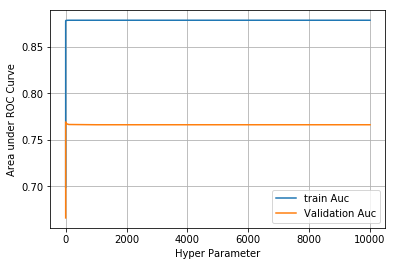

In [70]:
plt.plot(lambdaValues,aucTrain, label='train Auc')
plt.plot(lambdaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


### Observation 
we get maximum AUC Cv at lambda = 0.01

In [82]:
lrBow = LogisticRegression(penalty = 'l2', C = 0.001)
# train model knn with respect to ooptimalK
lrBow.fit(bowTrain, y_tr)

predTrain = lrBow.predict_proba(bowTrain)
predTest = lrBow.predict_proba(bowTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
aucTrain = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, predTest[:,1])
aucTest = metrics.auc(fpr2, tpr2)
    
y_pred = lrBow.predict(bowTest)


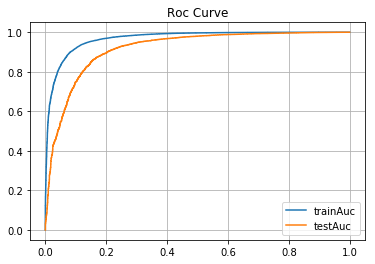

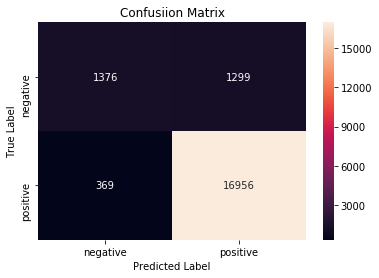

In [83]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [84]:
print(aucTest)

0.9168818977491875


In [85]:
tableData.add_row(['BOW', "l2", 0.001, aucTest])


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [86]:
# Generate random normal variable as a noise 
bowTrainPert = bowTrain
noise = np.random.normal(0, 0.0001, size = (bowTrainPert[np.nonzero(bowTrain)].size))
#print(noise.shape)
np.nonzero(bowTrainPert)
bowTrainPert[np.nonzero(bowTrainPert)] = noise + bowTrainPert[np.nonzero(bowTrainPert)]
bowTrainPert.shape

(60000, 5000)

In [87]:
bowTrainPert

<60000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1707530 stored elements in Compressed Sparse Row format>

In [88]:

modelGridBowPert = LogisticRegression(penalty = 'l2', C = 0.001)
modelGridBowPert.fit(bowTrainPert,y_tr)
weigtsPert = modelGridBowPert.coef_

In [89]:
weights = lrBow.coef_
weights.shape

(1, 5000)

In [90]:
diffWeight = []
#perturbation test
count = 0
for i in range(5000):
    weights[0][i] += 10**-6
    weigtsPert[0][i] += 10**-6
    diff = abs(weights[0][i] - weigtsPert[0][i])/abs(weights[0][i])
    diff *= 100
    diffWeight.append(diff)

In [91]:
sortDiffWeights = sorted(diffWeight, reverse=True)

In [92]:
len(sortDiffWeights)

5000

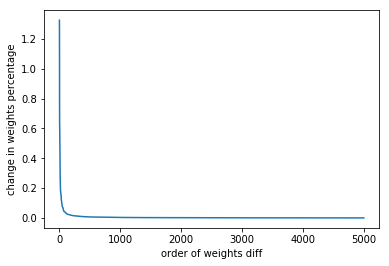

In [93]:
plt.plot([x for x in range(5000)], sortDiffWeights)
plt.xlabel("order of weights diff")
plt.ylabel("change in weights percentage")
plt.show()

In [94]:
sortDiffWeights[0:15]

[1.32441874556315,
 1.2481734349788494,
 0.6603135789589807,
 0.636879981433717,
 0.6262166951897162,
 0.5600680238388677,
 0.5529424596335981,
 0.5272457866755377,
 0.4798334592820892,
 0.42367118447644225,
 0.36417831503605885,
 0.32207407715588854,
 0.26708518422502675,
 0.2588953451765275,
 0.25325004138235213]

### Observation
by observing the plot and using the elbow method we get **tau** as 1 and there are 2 features which are multicolinear

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [95]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
weights = lrBow.coef_
weights.shape

(1, 5000)

In [96]:
bowData = pd.DataFrame({"features":count_vect.get_feature_names(), "Weights": weights[0]})
#sorting the weights
features = bowData.sort_values("Weights", ascending = False)

In [97]:
#TOP  10  POSITIVE features
features.head(10)

,features,Weights
1946,great,0.467259
2582,love,0.366770
377,best,0.329197
1170,delici,0.272842
1899,good,0.263155
1519,excel,0.229960
3212,perfect,0.213996
2943,nice,0.197978
4901,wonder,0.180243
1601,favorit,0.178871


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [98]:
# Please write all the code with proper documentation
#top 10 negative features
features.tail(10)

,features,Weights
4071,sorri,-0.105409
2124,horribl,-0.117882
2830,money,-0.118159
3649,return,-0.121147
4663,unfortun,-0.123471
417,bland,-0.123799
268,aw,-0.136704
4433,terribl,-0.139877
4917,worst,-0.189423
1252,disappoint,-0.223384


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [99]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
lambdaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [100]:
# Please write all the code with proper documentation
for lam in lambdaValues:
    lr = LogisticRegression(penalty = 'l1', C = lam)
    lr.fit(tfTrain, y_tr)
    predTrain = lr.predict_proba(tfTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = lr.predict_proba(tfCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(lam, " lambda iteration done")

0.0001  lambda iteration done
0.001  lambda iteration done
0.01  lambda iteration done
0.1  lambda iteration done
1  lambda iteration done
10  lambda iteration done
100  lambda iteration done
1000  lambda iteration done
10000  lambda iteration done


In [103]:
print(aucCv)

[0.5, 0.8555989611363253, 0.9406936389637551, 0.9323105814436897, 0.9164484938730818, 0.9115460678079543, 0.9089273922055564, 0.9069277809587053, 0.9056832089419731]


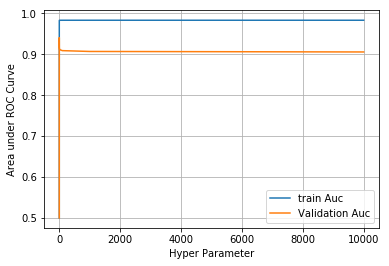

In [102]:
plt.plot(lambdaValues,aucTrain, label='train Auc')
plt.plot(lambdaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


## Observation 
for c = 0.01 we get maximum AUC for CV dataset

In [110]:
lrTf = LogisticRegression(penalty = 'l1', C = 0.01)
# train model knn with respect to ooptimalK
lrTf.fit(tfTrain, y_tr)

predTrain = lrTf.predict_proba(tfTrain)
predTest = lrTf.predict_proba(tfTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
aucTrain = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, predTest[:,1])
aucTest = metrics.auc(fpr2, tpr2)
y_pred = lrTf.predict(tfTest)
    
print(aucTest)

0.9430637159310056


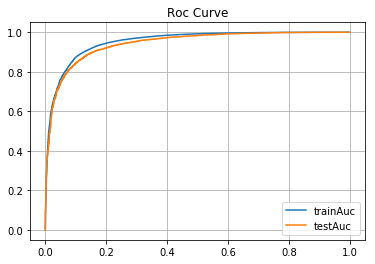

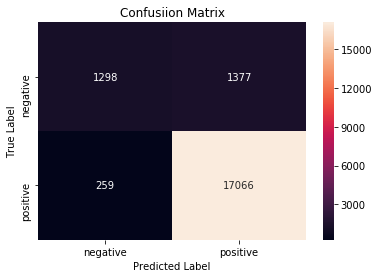

In [109]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [93]:
print(score3)

0.79042440425618


In [111]:
tableData.add_row(['TF-IDF', "l1", 0.01, aucTest])


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [112]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
lambdaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [113]:
# Please write all the code with proper documentation
for lam in lambdaValues:
    lr = LogisticRegression(penalty = 'l2', C = lam)
    lr.fit(tfTrain, y_tr)
    predTrain = lr.predict_proba(tfTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = lr.predict_proba(tfCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(lam, " lambda iteration done")

0.0001  lambda iteration done
0.001  lambda iteration done
0.01  lambda iteration done
0.1  lambda iteration done
1  lambda iteration done
10  lambda iteration done
100  lambda iteration done
1000  lambda iteration done
10000  lambda iteration done


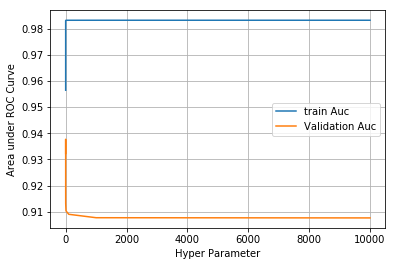

In [115]:
plt.plot(lambdaValues,aucTrain, label='train Auc')
plt.plot(lambdaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


In [118]:
aucCv

[0.9322721962425556,
 0.9377163458699711,
 0.928125432612519,
 0.9182816671413235,
 0.9130931371802375,
 0.9103423843750387,
 0.9090192779690853,
 0.9077039669066751,
 0.9076278830861557]

## Observation 
for c = 0.001 we get maximum AUC for CV dataset

In [119]:
lrTf = LogisticRegression(penalty = 'l2', C = 0.001)
# train model knn with respect to ooptimalK
lrTf.fit(tfTrain, y_tr)

predTrain = lrTf.predict_proba(tfTrain)
predTest = lrTf.predict_proba(tfTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
aucTrain = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, predTest[:,1])
aucTest = metrics.auc(fpr2, tpr2)
    
y_pred = lrTf.predict(tfTest)
aucTest

0.9413066526412319

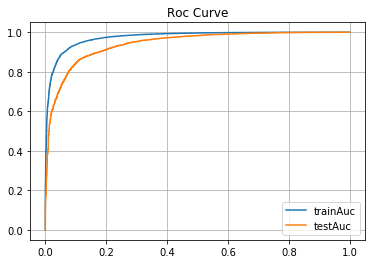

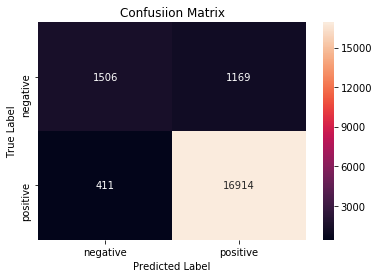

In [120]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [121]:
tableData.add_row(['TF-IDF', "l2", 0.001, aucTest])


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [124]:
# Please write all the code with proper documentation
weights = lrTf.coef_
weights.shape

(1, 5000)

In [125]:
tfData = pd.DataFrame({"features":tf_idf_vect.get_feature_names(), "Weights": weights[0]})
#sorting the weights
features = tfData.sort_values("Weights", ascending = False)

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [126]:
#TOP  10  POSITIVE features
features.head(10)

,features,Weights
1946,great,0.331643
2604,love,0.272972
346,best,0.257863
1041,delici,0.230209
1851,good,0.207608
3217,perfect,0.185469
1400,excel,0.182986
2957,nice,0.156814
4878,wonder,0.139451
2122,high recommend,0.139252


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [127]:
features.tail(10)

,features,Weights
2745,mayb,-0.091778
4632,unfortun,-0.096128
4450,threw,-0.098321
3635,return,-0.099388
2150,horribl,-0.104851
258,aw,-0.106565
408,bland,-0.114569
4393,terribl,-0.123794
4903,worst,-0.169156
1120,disappoint,-0.207462


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [128]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
lambdaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [129]:
# Please write all the code with proper 
for lam in lambdaValues:
    lr = LogisticRegression(penalty = 'l1', C = lam)
    lr.fit(avgTrain, y_tr)
    predTrain = lr.predict_proba(avgTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = lr.predict_proba(avgCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(lam, " lambda iteration done")

0.0001  lambda iteration done
0.001  lambda iteration done
0.01  lambda iteration done
0.1  lambda iteration done
1  lambda iteration done
10  lambda iteration done
100  lambda iteration done
1000  lambda iteration done
10000  lambda iteration done


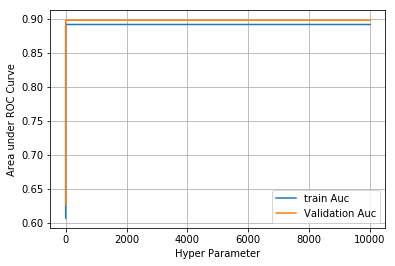

In [132]:
plt.plot(lambdaValues,aucTrain, label='train Auc')
plt.plot(lambdaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


In [133]:
aucCv

[0.6264635519839878,
 0.8674486544064575,
 0.8977879835983438,
 0.8979661779690452,
 0.8981983271023751,
 0.8982139389150542,
 0.8982529790095481,
 0.898255091568774,
 0.8982527255024412]

## Observation 
for c = 1000 we get maximum AUC for CV dataset

In [134]:
lrAvg = LogisticRegression(penalty = 'l1', C = 1000)
# train model knn with respect to ooptimalK
lrAvg.fit(avgTrain, y_tr)

predTrain = lrAvg.predict_proba(avgTrain)
predTest = lrAvg.predict_proba(avgTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
aucTrain = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, predTest[:,1])
aucTest = metrics.auc(fpr2, tpr2)

y_pred = lrAvg.predict(avgTest)

aucTest

0.8954719423878302

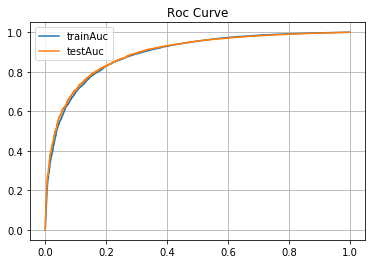

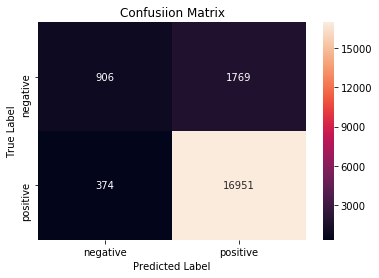

In [136]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [137]:
tableData.add_row(['Avg W2v', "l1", 1000, aucTest])

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [139]:
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
lambdaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [140]:
# Please write all the code with proper 
for lam in lambdaValues:
    lr = LogisticRegression(penalty = 'l2', C = lam)
    lr.fit(avgTrain, y_tr)
    predTrain = lr.predict_proba(avgTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = lr.predict_proba(avgCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(lam, " lambda iteration done")

0.0001  lambda iteration done
0.001  lambda iteration done
0.01  lambda iteration done
0.1  lambda iteration done
1  lambda iteration done
10  lambda iteration done
100  lambda iteration done
1000  lambda iteration done
10000  lambda iteration done


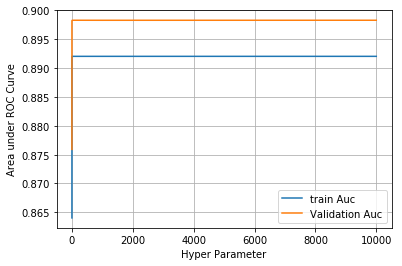

In [142]:
plt.plot(lambdaValues,aucTrain, label='train Auc')
plt.plot(lambdaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


In [143]:
aucCv

[0.8759024404094047,
 0.8968462680722312,
 0.8979480522108871,
 0.8980360825538289,
 0.898225114353359,
 0.8982612813673058,
 0.8982648515923974,
 0.8982584505379431,
 0.8982646614620672]

## Observation 
for c = 100 we get maximum AUC for CV dataset

In [145]:
lrAvg = LogisticRegression(penalty = 'l2', C = 100)
# train model knn with respect to ooptimalK
lrAvg.fit(avgTrain, y_tr)

predTrain = lrAvg.predict_proba(avgTrain)
predTest = lrAvg.predict_proba(avgTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
aucTrain = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, predTest[:,1])
aucTest = metrics.auc(fpr2, tpr2)
    
y_pred = lrAvg.predict(avgTest)

aucTest

0.895484414235816

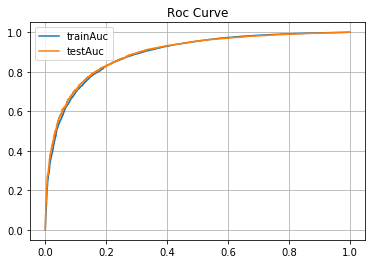

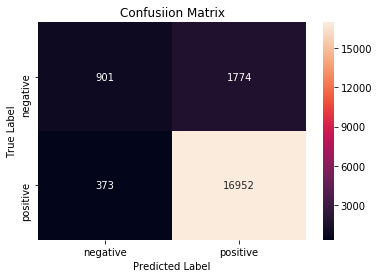

In [146]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [147]:
tableData.add_row(['Avg W2v', "l2", 100, aucTest])


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [149]:
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
lambdaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [150]:
# Please write all the code with proper 
for lam in lambdaValues:
    lr = LogisticRegression(penalty = 'l1', C = lam)
    lr.fit(tfAvgTrain, y_tr)
    predTrain = lr.predict_proba(tfAvgTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = lr.predict_proba(tfAvgCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(lam, " lambda iteration done")

0.0001  lambda iteration done
0.001  lambda iteration done
0.01  lambda iteration done
0.1  lambda iteration done
1  lambda iteration done
10  lambda iteration done
100  lambda iteration done
1000  lambda iteration done
10000  lambda iteration done


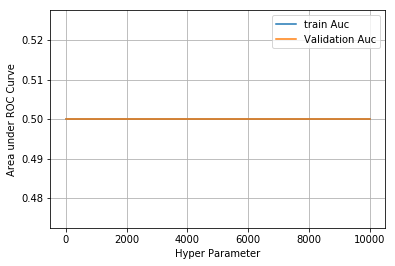

In [152]:
plt.plot(lambdaValues,aucTrain, label='train Auc')
plt.plot(lambdaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


In [153]:
aucCv

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

### Observation 
nothing is concluded

In [156]:
lrTfW2v = LogisticRegression(penalty = 'l1', C = 1)
# train model knn with respect to ooptimalK
lrTfW2v.fit(tfAvgTrain, y_tr)

predTrain = lrTfW2v.predict_proba(tfAvgTrain)
predTest = lrTfW2v.predict_proba(tfAvgTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
aucTrain = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, predTest[:,1])
aucTest = metrics.auc(fpr2, tpr2)

y_pred = lrTfW2v.predict(tfAvgTest)



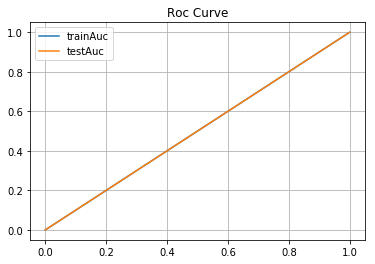

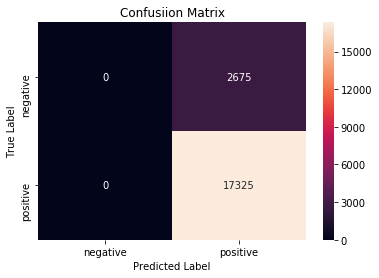

In [157]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(fpr2,tpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, y_pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [160]:
tableData.add_row(['Tfidf W2v', "l1", 1, aucTest])


In [161]:
print(tableData)

+------------+---------+--------+--------------------+
| Vectorizer | penalty | lambda |        AUC         |
+------------+---------+--------+--------------------+
|    BOW     |    l1   |  0.01  | 0.9283537214602635 |
|    BOW     |    l2   |  0.01  | 0.8979192404687732 |
|    BOW     |    l2   | 0.001  | 0.9168818977491875 |
|   TF-IDF   |    l1   |  0.01  | 0.9430637159310056 |
|   TF-IDF   |    l2   | 0.001  | 0.9413066526412319 |
|  Avg W2v   |    l1   |  1000  | 0.8954719423878302 |
|  Avg W2v   |    l2   |  100   | 0.895484414235816  |
| Tfidf W2v  |    l1   |   1    |        0.5         |
+------------+---------+--------+--------------------+


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [162]:
# Please write all the code with proper documentation
aucTrain = [ x for x in range(9)]
aucCv = [ x for x in range(9)]
lambdaValues = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
j = 0

In [164]:
# Please write all the code with proper 
for lam in lambdaValues:
    lr = LogisticRegression(penalty = 'l2', C = lam)
    lr.fit(tfAvgTrain, y_tr)
    predTrain = lr.predict_proba(tfAvgTrain)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
    aucTrain[j] = metrics.auc(fpr, tpr)
    
    predCv = lr.predict_proba(tfAvgCv)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, predCv[:,1])
    aucCv[j] = metrics.auc(fpr, tpr)
    j += 1
    print(lam, " lambda iteration done")

0.0001  lambda iteration done
0.001  lambda iteration done
0.01  lambda iteration done
0.1  lambda iteration done
1  lambda iteration done
10  lambda iteration done
100  lambda iteration done
1000  lambda iteration done
10000  lambda iteration done


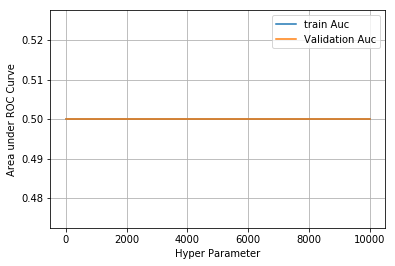

In [165]:
plt.plot(lambdaValues,aucTrain, label='train Auc')
plt.plot(lambdaValues, aucCv, label='Validation Auc')
plt.xlabel('Hyper Parameter')
plt.ylabel('Area under ROC Curve')
plt.grid()
plt.legend()
plt.show()


In [168]:
lrTfW2v = LogisticRegression(penalty = 'l2', C = 1)
# train model knn with respect to ooptimalK
lrTfW2v.fit(tfAvgTrain, y_tr)

predTrain = lrTfW2v.predict_proba(tfAvgTrain)
predTest = lrTfW2v.predict_proba(tfAvgTest)

fpr1, tpr1, thresholds = metrics.roc_curve(y_tr, predTrain[:,1])
aucTrain = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds = metrics.roc_curve(y_test, predTest[:,1])
aucTest = metrics.auc(fpr2, tpr2)
    
y_pred = lrTfW2v.predict(tfAvgTest)


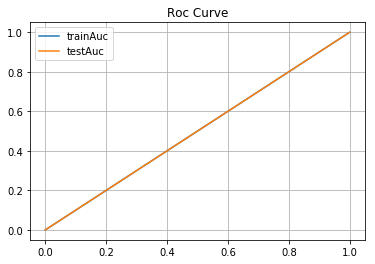

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [169]:
# plot confusion matrix to describe the performance of classifier.

plt.title("Roc Curve")
plt.plot(fpr1,tpr1,label="trainAuc")
plt.plot(tpr2,fpr2,label="testAuc")
plt.grid()
plt.legend()
plt.show()
    
# confusion matrix
    
cm = confusion_matrix(y_test, predTest)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

score4 = metrics.roc_auc_score(y_test, y_pred)


In [172]:
tableData.add_row(['Tfidf -W2v', "l2", 1, aucTest])


# [6] Conclusions

In [176]:
# Please compare all your models using Prettytable library
print(tableData)

+------------+---------+--------+--------------------+
| Vectorizer | penalty | lambda |        AUC         |
+------------+---------+--------+--------------------+
|    BOW     |    l1   |  0.01  | 0.9283537214602635 |
|    BOW     |    l2   | 0.001  | 0.9168818977491875 |
|   TF-IDF   |    l1   |  0.01  | 0.9430637159310056 |
|   TF-IDF   |    l2   | 0.001  | 0.9413066526412319 |
|  Avg W2v   |    l1   |  1000  | 0.8954719423878302 |
|  Avg W2v   |    l2   |  100   | 0.895484414235816  |
| Tfidf W2v  |    l1   |   1    |        0.5         |
| Tfidf W2v  |    l2   |   1    |        0.5         |
+------------+---------+--------+--------------------+


#### Observation
For Tf-Idf with l1 regularizer and C = 0.01 we get the maximum efficiency